# LOESS Regression for calculating stop percentiles

This test is broken into the following sections:

- [Collecting data](#collecting-data)
- [Build the DataFrame](build-the-dataframe)
- [LOESS Regression](run-linear-regression-on-the-data)
- [Standard Deviation and SMA](#standard-deviation-and-sma)

The goal is to run LOESS regression over 288 5min candle closes for bitcoin. Then, we will caculate the standard deviation and measure two bands above and below the LOESS Regression line. This will act as a guide as to where we want to set our stop loss to in the event our system opens a contradicting position to the direction the market is going in. Otherwise the stop-loss will be fixed as $n$.

On the live system, we have data coming in via a websocket, therefore we need an algorithm to dynamically update our stop-loss as the new data changes the calculations. Speed will be an important factor as to limit the time between new price data ticks and submiting a succefful order to the book.

The first step will be to import all the relevant libraries and set any matplotlib parameters:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import dateutil.parser
import requests
from typing import List, Dict

# from sklearn.linear_model import LinearRegression 
from scipy.stats import linregress, zscore
from scipy.interpolate import interp1d
import statsmodels.api as sm

%matplotlib inline
plt.rcParams['figure.figsize'] = [17, 7]

# Collecting Data

The next step is to build a function that collects our data from Bitmex using the REST API.

In [111]:
def collect_data(from_time: str, to_time: str, tf: str, contract: str = "ETHUSD") -> pd.DataFrame:

    url = "https://www.bitmex.com/api/v1/trade/bucketed"
    candles = {'timestamp': [], 'close': []}

    # Set inputs
    data = dict()
    data['symbol'] = contract
    data['partial'] = True  # returns a candle if it is not finished yet
    data['binSize'] = tf
    data['count'] = 500   # how many candles we can return (500 max)
    data['reverse'] = True

    data["startTime"] = datetime.datetime.strptime(from_time, '%Y-%m-%d %H:%M')
    data["endTime"] = datetime.datetime.strptime(to_time, '%Y-%m-%d %H:%M')

    BITMEX_TF_MINUTES = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "1d": 1440}


    try:
        response = requests.get(url, params=data)
    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        raw_candles = response.json()
    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if raw_candles is not None:
        for idx, c in enumerate(reversed(raw_candles)):
            ts = dateutil.parser.isoparse(c['timestamp'])
            ts = ts - datetime.timedelta(minutes=BITMEX_TF_MINUTES[tf])
            candles['timestamp'].append(ts)
            candles["close"].append(c["close"])


    return pd.DataFrame(candles)

### Build the DataFrame



In [141]:
from_time = "2022-06-25 13:00"
to_time = "2022-06-26 13:00"
tf = "5m"
contract = "XBTUSD"

data = collect_data(from_time, to_time, tf, contract)

data['timestamp'] = pd.to_datetime(data['timestamp'], format='%H:%M')
data['sma_30'] = data['close'].rolling(window=30).mean()
data

,timestamp,close,sma_30
0,2022-06-25 12:55:00+00:00,21124.0,NaN
1,2022-06-25 13:00:00+00:00,21050.5,NaN
2,2022-06-25 13:05:00+00:00,21097.5,NaN
3,2022-06-25 13:10:00+00:00,21132.0,NaN
4,2022-06-25 13:15:00+00:00,21142.5,NaN
...,...,...,...
280,2022-06-26 12:15:00+00:00,21700.5,21464.916667
281,2022-06-26 12:20:00+00:00,21635.0,21472.816667
282,2022-06-26 12:25:00+00:00,21582.5,21479.050000
283,2022-06-26 12:30:00+00:00,21613.0,21486.716667


# LOESS Regression

Now we apply LOESS regression to the data using the timestamp (index in this case), as the $x$ value, and the close price as the $y$ value.

In [142]:
# lowess will return our "smoothed" data with a y value for at every x-value
x = data.index
y = data['close']

title = f"{contract} - {tf}: {from_time} - {to_time}"

lowess = sm.nonparametric.lowess(y, x, frac=.3)


Plot the regression line over the data.

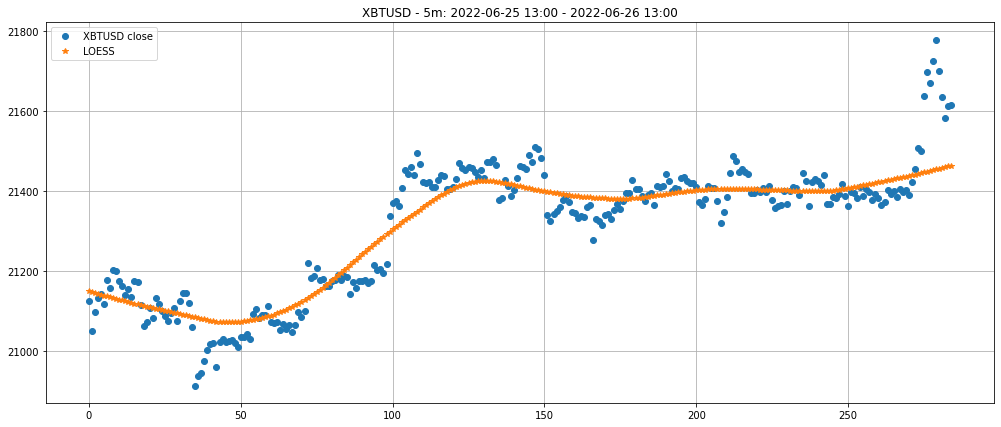

In [143]:
plt.plot(x, y, 'o', label=f"{contract} close")
plt.plot(lowess[:,0], lowess[:,1], "*", label="LOESS")

plt.title(title)
plt.grid()
plt.legend()
plt.show()

# Standard Deviation and SMA

Now we calculate the standard deviation. On this timeframe it can be quite large for the data we are using so we only go as high as the LOESS value + a full standard deviation.
We apply it to the DataFrame as:
- upper band +1: LOESS + (standard deviation / 2)
- upper band +2: LOESS + standard deviation
- lower band -1: LOESS - (standard deviation / 2)
- lower band -2: LOESS - standard deviation

A SMA of 30 is also added to compare the difference.

In [144]:
data['LOWESS'] = lowess[:,1]

std_dev = round(np.std(lowess[:,1]),3)
data['upper_band_1'] = data['LOWESS'] + std_dev/2
data['upper_band_2'] = data['LOWESS'] + std_dev
data['lower_band_1'] = data['LOWESS'] - std_dev/2
data['lower_band_2'] = data['LOWESS'] - std_dev

data

,timestamp,close,sma_30,LOWESS,upper_band_1,upper_band_2,lower_band_1,lower_band_2
0,2022-06-25 12:55:00+00:00,21124.0,NaN,21149.023310,21216.701810,21284.380310,21081.344810,21013.666310
1,2022-06-25 13:00:00+00:00,21050.5,NaN,21146.908019,21214.586519,21282.265019,21079.229519,21011.551019
2,2022-06-25 13:05:00+00:00,21097.5,NaN,21144.799026,21212.477526,21280.156026,21077.120526,21009.442026
3,2022-06-25 13:10:00+00:00,21132.0,NaN,21142.697299,21210.375799,21278.054299,21075.018799,21007.340299
4,2022-06-25 13:15:00+00:00,21142.5,NaN,21140.604027,21208.282527,21275.961027,21072.925527,21005.247027
...,...,...,...,...,...,...,...,...
280,2022-06-26 12:15:00+00:00,21700.5,21464.916667,21456.176242,21523.854742,21591.533242,21388.497742,21320.819242
281,2022-06-26 12:20:00+00:00,21635.0,21472.816667,21458.125753,21525.804253,21593.482753,21390.447253,21322.768753
282,2022-06-26 12:25:00+00:00,21582.5,21479.050000,21460.108907,21527.787407,21595.465907,21392.430407,21324.751907
283,2022-06-26 12:30:00+00:00,21613.0,21486.716667,21462.126304,21529.804804,21597.483304,21394.447804,21326.769304


Plot the results.

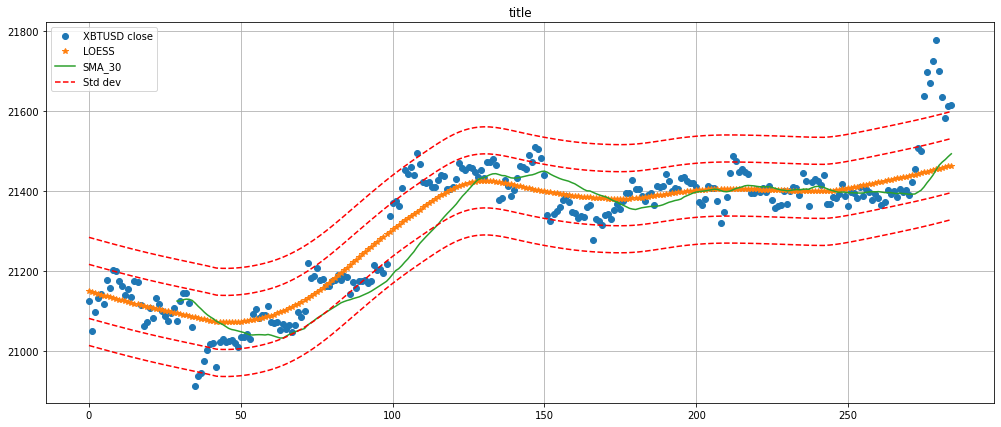

In [145]:
plt.plot(x, y, 'o', label=f"{contract} close")
plt.plot(lowess[:,0], lowess[:,1], "*", label="LOESS")
plt.plot(x, data['sma_30'], label="SMA_30")

plt.plot(x, data['upper_band_1'], "r--", label="Std dev")
plt.plot(x, data['upper_band_2'], "r--")
plt.plot(x, data['lower_band_1'], "r--")
plt.plot(x, data['lower_band_2'], "r--")

plt.title("title")
plt.grid()
plt.legend()
plt.show()

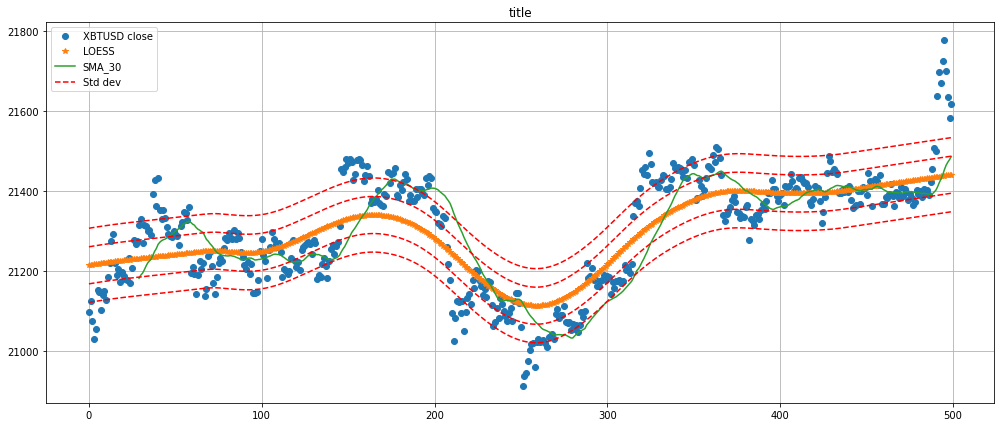

In [140]:
plt.plot(x, y, 'o', label=f"{contract} close")
plt.plot(lowess[:,0], lowess[:,1], "*", label="LOESS")
plt.plot(x, data['sma_30'], label="SMA_30")

plt.plot(x, data['upper_band_1'], "r--", label="Std dev")
plt.plot(x, data['upper_band_2'], "r--")
plt.plot(x, data['lower_band_1'], "r--")
plt.plot(x, data['lower_band_2'], "r--")

plt.title("title")
plt.grid()
plt.legend()
plt.show()